If you have the ERA5 data, wave analysis file, and model data collected in one directory and named as in All_figs_data_setup.ipynb, this notebook should be able to replicate Figure 5 in Bartusek et al., 2022, _Nat. Clim. Change_.

Sam Bartusek, 2021

## _Data setup notebook (~15 min)_

In [1]:
%run ./All_figs_data_setup.ipynb


/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  5min  3.1s


./All_figs_data_setup.ipynb:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "cell_type": "markdown",


In [2]:
# Climatology over all of june–july

climspec = xr.open_mfdataset(glob.glob(path + 'ERA5*19812010clim*nh.nc'),combine='by_coords')
climspec['t2m'] = climspec.t2m - 273.15
climspec['t2mland'] = climspec.t2m.where(landmask>.5)
climspec['skt'] = climspec.skt - 273.15
climspec['sktland'] = climspec.skt.where(landmask>.5)
climspec['z'] = climspec.z / 9.81
climspec['swvl1'] = climspec.swvl1.where(landmask>.5)
climspec['speed'] = (climspec.u**2 + climspec.v**2)**(1/2)
climspec = climspec.drop('time_bnds')
climspec
climspec['time'] = (climspec.time.to_pandas() + pd.offsets.DateOffset(years=11)).values


# Calculate daily-mean anomalies over all of June–July up to 2020

test = rawto20[['sktland','swvl1','t2mland','z']].sel(time=(rawto20.time.dt.month == 6) | (rawto20.time.dt.month == 7))
test.coords['time'] = test.time.dt.floor('1D')
test = test.groupby('time').mean()
month_day_str_raw = xr.DataArray(test.indexes['time'].strftime('%m-%d'), coords=test.time.coords)
test['month_day_str'] = month_day_str_raw

temp = climspec[['sktland','swvl1','t2mland','z']].sel(time=(climspec.time.dt.month == 6) | (climspec.time.dt.month == 7)).resample(time='1D').mean()
month_day_str_clim = xr.DataArray(temp.indexes['time'].strftime('%m-%d'), coords=temp.time.coords)
temp['month_day_str'] = month_day_str_clim
anomsliceto20 = test.groupby('month_day_str') - temp.groupby('month_day_str').mean()


# Take spatial mean over PNW

with pbar:
    anomsliceto20_pnw_mean = anomsliceto20.sel(latitude=pnwlat,longitude=pnwlon).weighted(weights).mean(('latitude','longitude')).compute()


[                                        ] | 0% Completed | 11.0s

/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 13min 53.4s


In [66]:
# Select date range within June–July

junelim = 1   #23-1  #1   (i.e., select days >= to this date)   (if calculating 3-day means for partial month specify one day outside the desired range)
julylim = 31   #5+1  #31   (i.e., select days <= to this date)   (if calculating 3-day means for partial month specify one day outside the desired range)
timeslice = slice(f'2021-06-{junelim}',f'2021-07-{julylim}') 
tt = ((anomsliceto20_pnw_mean.time.dt.month == 6) & (anomsliceto20_pnw_mean.time.dt.day >= junelim)) | ((anomsliceto20_pnw_mean.time.dt.month == 7) & (anomsliceto20_pnw_mean.time.dt.day <= julylim))


# Select time-averaging window

days = 1


# Separate into historical periods

qq79 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1979','1999')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq00 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('2000','2020')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq81 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1981','2010')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq91 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1991','2020')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq20 = anomsliceto20_pnw_mean.sel(time=tt).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq21 = anomdaily_pnw_mean.sel(time=timeslice).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq = xr.merge([qq20,qq21])
eventlim = ((qq21.time.dt.month==6) & (qq21.time.dt.day>=23)) | ((qq21.time.dt.month==7) & (qq21.time.dt.day<=5))

qq80 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1980','2000')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq81 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1981','2001')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq82 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1982','2002')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq83 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1983','2003')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq84 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1984','2004')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq85 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1985','2005')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq86 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1986','2006')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq87 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1987','2007')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq88 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1988','2008')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq89 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1989','2009')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq90 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1990','2010')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq91 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1991','2011')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq92 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1992','2012')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq93 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1993','2013')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq94 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1994','2014')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq95 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1995','2015')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq96 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1996','2016')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq97 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1997','2017')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq98 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1998','2018')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq99 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('1999','2019')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq05 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('2005','2020')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')
qq10 = anomsliceto20_pnw_mean.sel(time=tt).sel(time=slice('2010','2020')).resample(time='1D').mean().rolling(time=days,center=True).mean().dropna('time')

fac = len(qq20.sel(time='2020').time)


# Fit skew normal distributions

points = np.arange(-12,12.02,.02)
# p21 = np.argwhere(np.round(points,3)>=np.round(qq21.t2mland.max().values,3))[0][0]
p21 = np.argwhere(points>=qq21.t2mland.max().values)[0][0]

fit79 = scipy.stats.skewnorm.fit(qq79.t2mland)
pdf79 = scipy.stats.skewnorm.pdf(points, *fit79)
sf79 = scipy.stats.skewnorm.sf(points, *fit79)

fit81 = scipy.stats.skewnorm.fit(qq81.t2mland)
pdf81 = scipy.stats.skewnorm.pdf(points, *fit81)
sf81 = scipy.stats.skewnorm.sf(points, *fit81)

fit91 = scipy.stats.skewnorm.fit(qq91.t2mland)
pdf91 = scipy.stats.skewnorm.pdf(points, *fit91)
sf91 = scipy.stats.skewnorm.sf(points, *fit91)

fit00 = scipy.stats.skewnorm.fit(qq00.t2mland)
pdf00 = scipy.stats.skewnorm.pdf(points, *fit00)
sf00 = scipy.stats.skewnorm.sf(points, *fit00)

fit21 = scipy.stats.skewnorm.fit(qq.t2mland)
pdf21 = scipy.stats.skewnorm.pdf(points, *fit21)
sf21 = scipy.stats.skewnorm.sf(points, *fit21)

fit80 = scipy.stats.skewnorm.fit(qq80.t2mland)
pdf80 = scipy.stats.skewnorm.pdf(points, *fit80)
sf80 = scipy.stats.skewnorm.sf(points, *fit80)

fit81 = scipy.stats.skewnorm.fit(qq81.t2mland)
pdf81 = scipy.stats.skewnorm.pdf(points, *fit81)
sf81 = scipy.stats.skewnorm.sf(points, *fit81)

fit82 = scipy.stats.skewnorm.fit(qq82.t2mland)
pdf82 = scipy.stats.skewnorm.pdf(points, *fit82)
sf82 = scipy.stats.skewnorm.sf(points, *fit82)

fit83 = scipy.stats.skewnorm.fit(qq83.t2mland)
pdf83 = scipy.stats.skewnorm.pdf(points, *fit83)
sf83 = scipy.stats.skewnorm.sf(points, *fit83)

fit84 = scipy.stats.skewnorm.fit(qq84.t2mland)
pdf84 = scipy.stats.skewnorm.pdf(points, *fit84)
sf84 = scipy.stats.skewnorm.sf(points, *fit84)

fit85 = scipy.stats.skewnorm.fit(qq85.t2mland)
pdf85 = scipy.stats.skewnorm.pdf(points, *fit85)
sf85 = scipy.stats.skewnorm.sf(points, *fit85)

fit86 = scipy.stats.skewnorm.fit(qq86.t2mland)
pdf86 = scipy.stats.skewnorm.pdf(points, *fit86)
sf86 = scipy.stats.skewnorm.sf(points, *fit86)

fit87 = scipy.stats.skewnorm.fit(qq87.t2mland)
pdf87 = scipy.stats.skewnorm.pdf(points, *fit87)
sf87 = scipy.stats.skewnorm.sf(points, *fit87)

fit88 = scipy.stats.skewnorm.fit(qq88.t2mland)
pdf88 = scipy.stats.skewnorm.pdf(points, *fit88)
sf88 = scipy.stats.skewnorm.sf(points, *fit88)

fit89 = scipy.stats.skewnorm.fit(qq89.t2mland)
pdf89 = scipy.stats.skewnorm.pdf(points, *fit89)
sf89 = scipy.stats.skewnorm.sf(points, *fit89)

fit90 = scipy.stats.skewnorm.fit(qq90.t2mland)
pdf90 = scipy.stats.skewnorm.pdf(points, *fit90)
sf90 = scipy.stats.skewnorm.sf(points, *fit90)

fit91 = scipy.stats.skewnorm.fit(qq91.t2mland)
pdf91 = scipy.stats.skewnorm.pdf(points, *fit91)
sf91 = scipy.stats.skewnorm.sf(points, *fit91)

fit92 = scipy.stats.skewnorm.fit(qq92.t2mland)
pdf92 = scipy.stats.skewnorm.pdf(points, *fit92)
sf92 = scipy.stats.skewnorm.sf(points, *fit92)

fit93 = scipy.stats.skewnorm.fit(qq93.t2mland)
pdf93 = scipy.stats.skewnorm.pdf(points, *fit93)
sf93 = scipy.stats.skewnorm.sf(points, *fit93)

fit94 = scipy.stats.skewnorm.fit(qq94.t2mland)
pdf94 = scipy.stats.skewnorm.pdf(points, *fit94)
sf94 = scipy.stats.skewnorm.sf(points, *fit94)

fit95 = scipy.stats.skewnorm.fit(qq95.t2mland)
pdf95 = scipy.stats.skewnorm.pdf(points, *fit95)
sf95 = scipy.stats.skewnorm.sf(points, *fit95)

fit96 = scipy.stats.skewnorm.fit(qq96.t2mland)
pdf96 = scipy.stats.skewnorm.pdf(points, *fit96)
sf96 = scipy.stats.skewnorm.sf(points, *fit96)

fit97 = scipy.stats.skewnorm.fit(qq97.t2mland)
pdf97 = scipy.stats.skewnorm.pdf(points, *fit97)
sf97 = scipy.stats.skewnorm.sf(points, *fit97)

fit98 = scipy.stats.skewnorm.fit(qq98.t2mland)
pdf98 = scipy.stats.skewnorm.pdf(points, *fit98)
sf98 = scipy.stats.skewnorm.sf(points, *fit98)

fit99 = scipy.stats.skewnorm.fit(qq99.t2mland)
pdf99 = scipy.stats.skewnorm.pdf(points, *fit99)
sf99 = scipy.stats.skewnorm.sf(points, *fit99)

fit05 = scipy.stats.skewnorm.fit(qq05.t2mland)
pdf05 = scipy.stats.skewnorm.pdf(points, *fit05)
sf05 = scipy.stats.skewnorm.sf(points, *fit05)

fit10 = scipy.stats.skewnorm.fit(qq10.t2mland)
pdf10 = scipy.stats.skewnorm.pdf(points, *fit10)
sf10 = scipy.stats.skewnorm.sf(points, *fit10)


## _5a)_

Text(0, 0.5, 'Probability density')

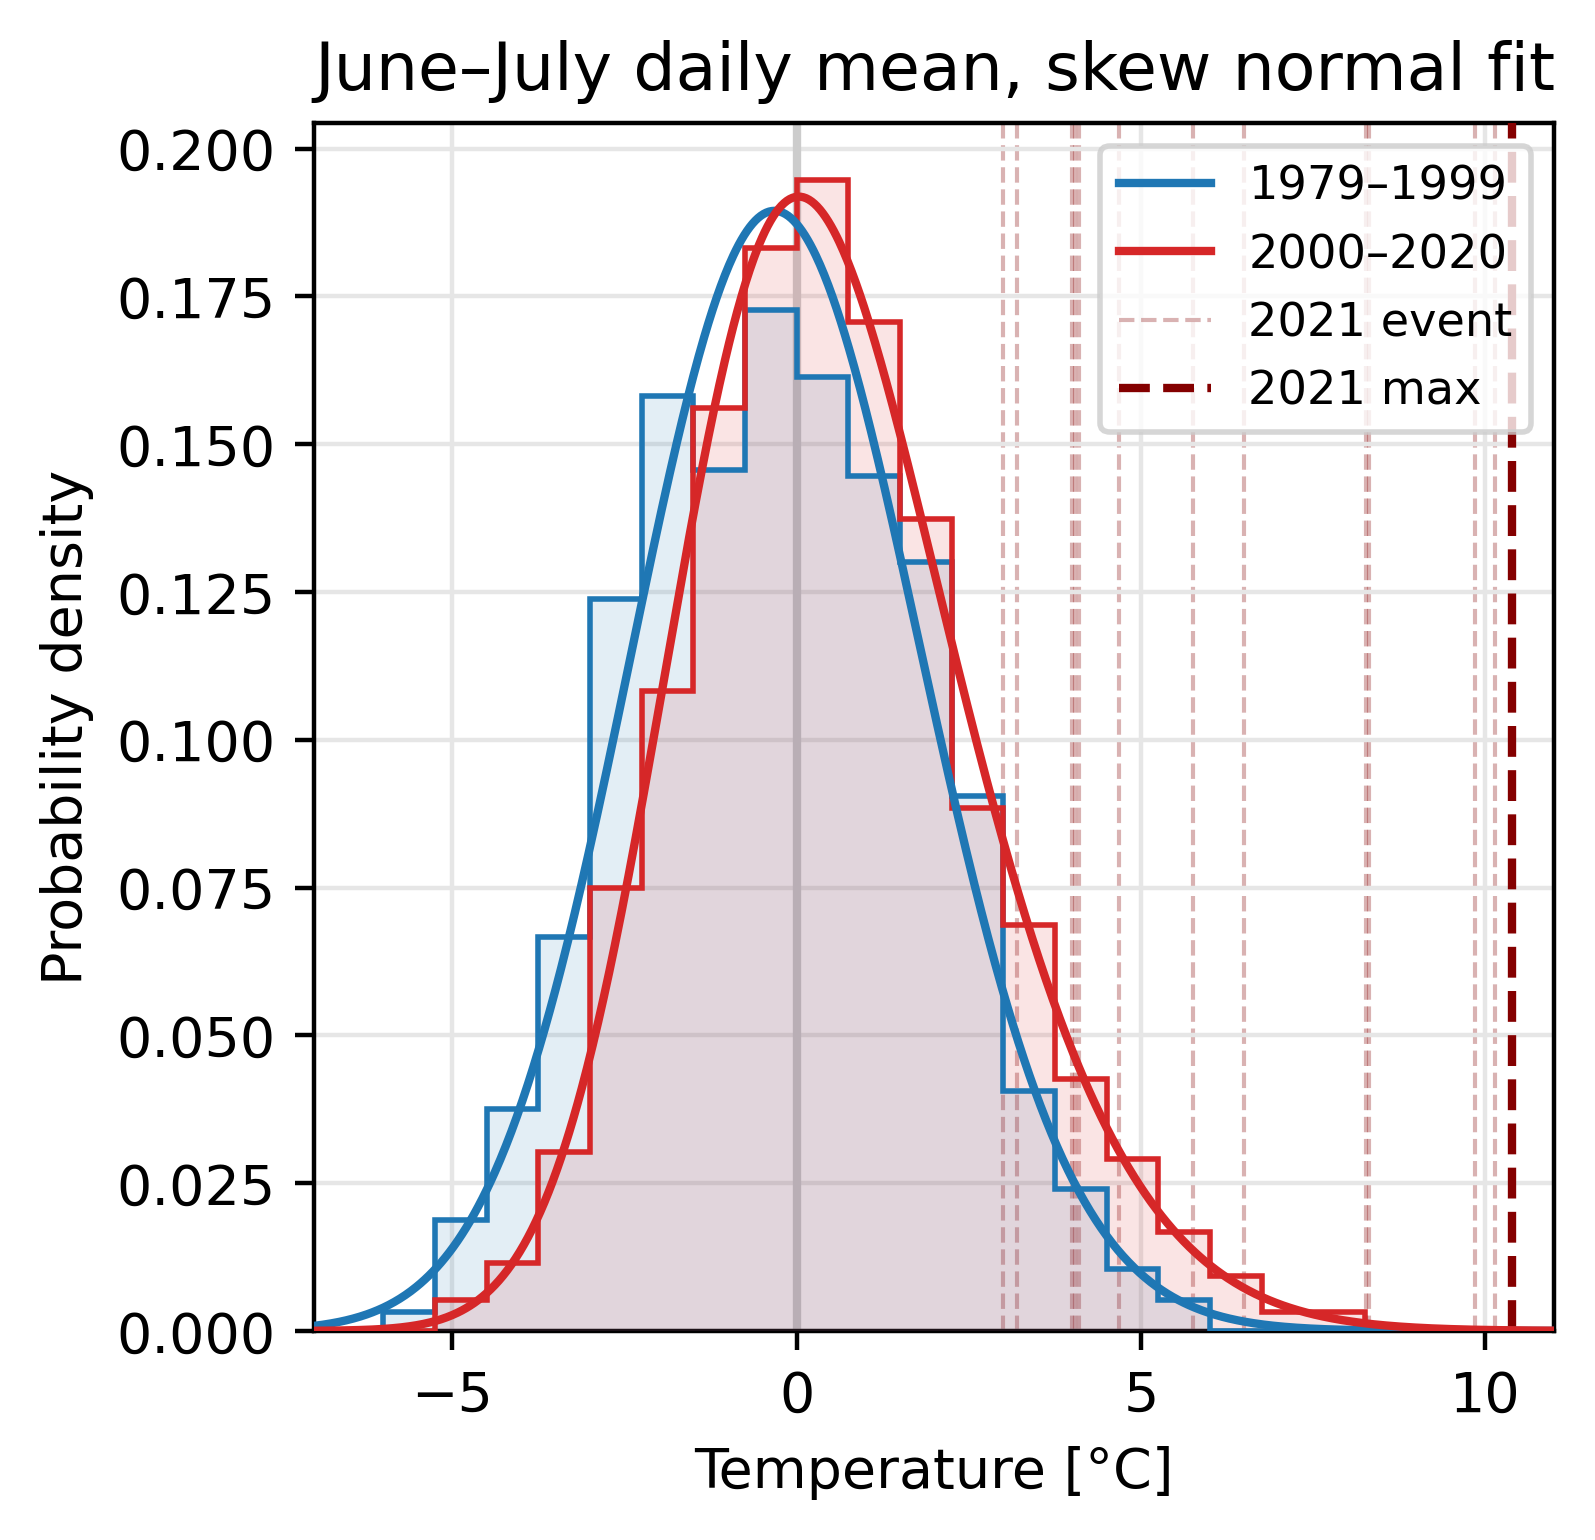

In [6]:
# Plot

plt.figure(dpi=200,figsize=(4,4))
plt.grid(c='.9',zorder=1)
plt.axvline(0,c='.8')
qq79.t2mland.plot.hist(bins=np.arange(np.min(points),np.max(points)+.75,.75),color='tab:blue',alpha=.12,histtype='bar',density=True,zorder=3)
qq79.t2mland.plot.hist(bins=np.arange(np.min(points),np.max(points)+.75,.75),color='tab:blue',alpha=1,histtype='step',density=True,zorder=5)
qq00.t2mland.plot.hist(bins=np.arange(np.min(points),np.max(points)+.75,.75),color='tab:red',alpha=.12,histtype='bar',density=True,zorder=3)
qq00.t2mland.plot.hist(bins=np.arange(np.min(points),np.max(points)+.75,.75),color='tab:red',alpha=1,histtype='step',density=True,zorder=5)
plt.plot(points,pdf79,color='tab:blue',alpha=1,label='1979–1999',zorder=301)
plt.plot(points,pdf00,color='tab:red',alpha=1,label='2000–2020',zorder=301)
plt.title('')

xcoords = qq21.t2mland[qq21.t2mland<qq21.t2mland.max()].where(eventlim,drop=True)
plt.axvline(x=xcoords[0],c='xkcd:dark red',lw=.75,ls='--',alpha=.3,zorder=1,label='2021 event')
for xc in xcoords[1:]:
    plt.axvline(x=xc,c='xkcd:dark red',lw=.75,ls='--',alpha=.3,zorder=1)
plt.axvline(np.round(qq21.t2mland.max().values,2),c='xkcd:dark red',ls='--',label='2021 max',zorder=4)

plt.legend(fontsize='small',loc='upper right').set_zorder(400)
plt.xlim(-7,11)
plt.title('June–July daily mean, skew normal fit',loc='left')
plt.xlabel('Temperature anomaly [°C]')
plt.ylabel('Probability density')



In [67]:
# # Calculate bootstraps:

# reps = 1000  # 25 min?

# n = len(qq79.t2mland)
# xb79 = np.random.choice(qq79.t2mland, (n, reps))
# n = len(qq81.t2mland)
# xb81 = np.random.choice(qq81.t2mland, (n, reps))
# n = len(qq91.t2mland)
# xb91 = np.random.choice(qq91.t2mland, (n, reps))
# n = len(qq00.t2mland)
# xb00 = np.random.choice(qq00.t2mland, (n, reps))

# sf79_b = np.zeros((len(points),reps))
# sf81_b = np.zeros((len(points),reps))
# sf91_b = np.zeros((len(points),reps))
# sf00_b = np.zeros((len(points),reps))

# for xx in range(reps):
#     fit = scipy.stats.skewnorm.fit(xb79[:,xx])
#     sf79_b[:,xx] = scipy.stats.skewnorm.sf(points, *fit)
#     fit = scipy.stats.skewnorm.fit(xb00[:,xx])
#     sf00_b[:,xx] = scipy.stats.skewnorm.sf(points, *fit)
    
#     if not xx % 100:
#         print(xx)
        
# xr.DataArray(data = sf79_b, dims = ['points','reps'],coords = dict(points = ('points', points), reps = ('reps', np.arange(1,reps+1)) ) ).to_netcdf('sf79_b.nc')
# xr.DataArray(data = sf00_b, dims = ['points','reps'],coords = dict(points = ('points', points), reps = ('reps', np.arange(1,reps+1)) ) ).to_netcdf('sf00_b.nc')


# Open from .nc

sf79_b = xr.open_dataarray('sf79_b.nc')
sf00_b = xr.open_dataarray('sf00_b.nc')

sf79_2p5,sf79_5,sf79_10,sf79_125,sf79_25,sf79_50,sf79_75,sf79_875,sf79_90,sf79_95,sf79_97p5 = np.percentile(sf79_b,[2.5,5,10,12.5,25,50,75,87.5,90,95,97.5],axis=1)
sf00_2p5,sf00_5,sf00_10,sf00_125,sf00_25,sf00_50,sf00_75,sf00_875,sf00_90,sf00_95,sf00_97p5 = np.percentile(sf00_b,[2.5,5,10,12.5,25,50,75,87.5,90,95,97.5],axis=1)


## _5b)_

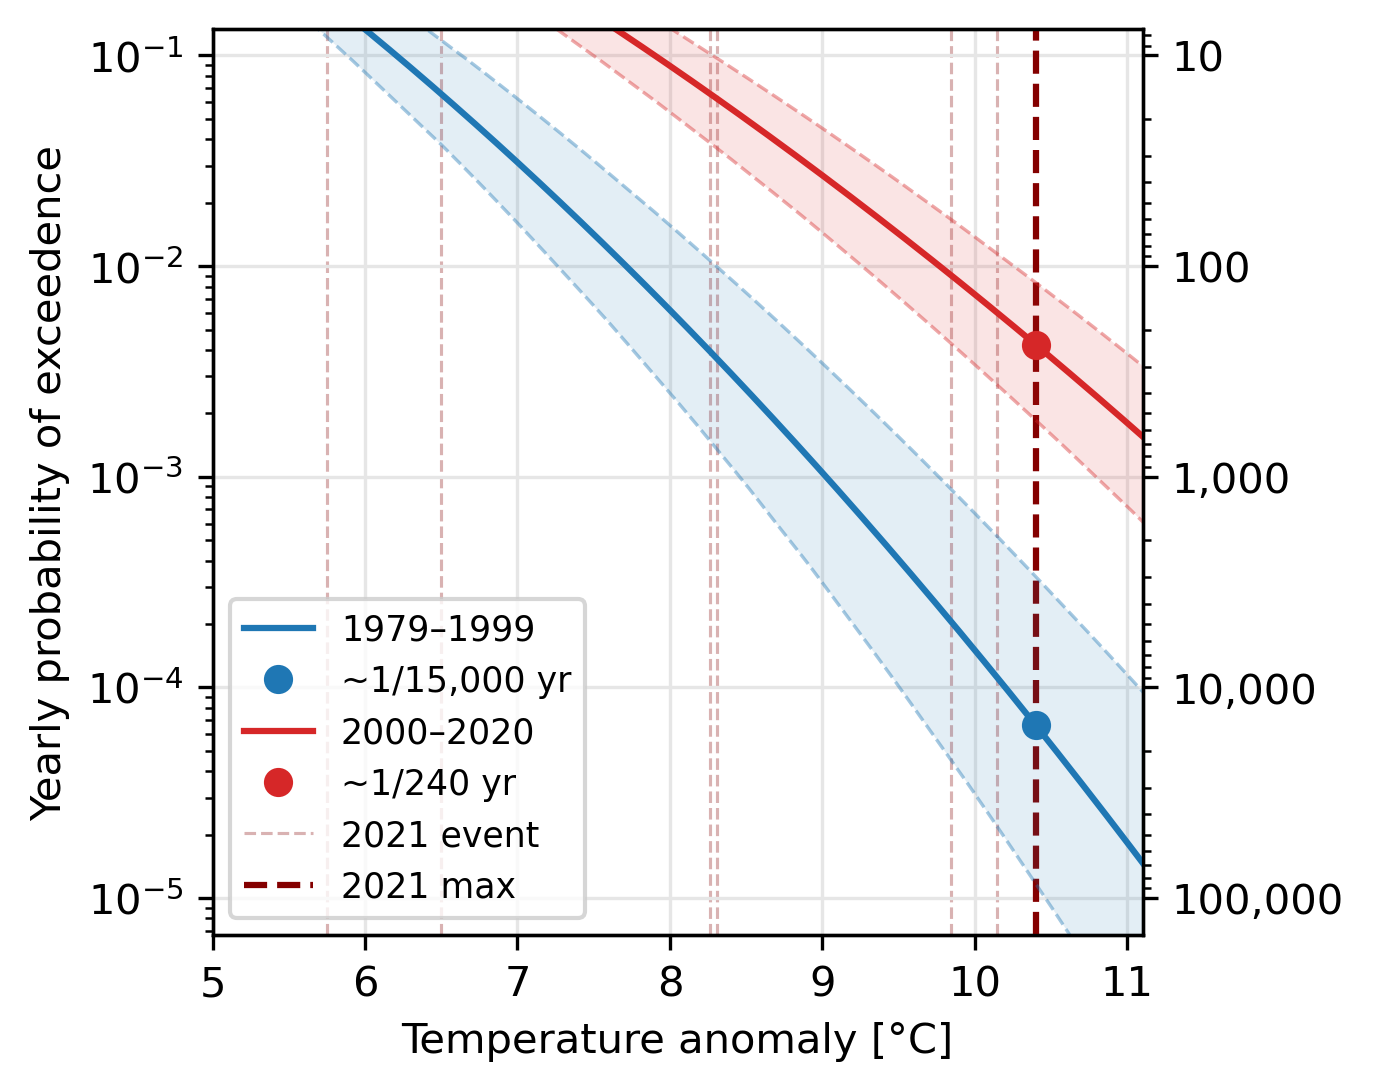

In [74]:
fac = len(qq20.sel(time='2020').time)

fig,ax = plt.subplots(1,1,dpi=150,figsize=(4,4))
ax2 = ax.twinx()

ax.grid(c='.9',zorder=1)
ax.plot(points,sf79*fac,color='tab:blue',lw=1.5,label='1979–1999',zorder=101)
ax.fill_between(points,sf79_5*fac,sf79_95*fac,color='tab:blue',edgecolor='none',alpha=.12,zorder=101)
ax.plot(points[p21],sf79[p21]*fac,color='tab:blue',ls='none',marker='o',label=f'~1/{int(round_to_n(1/sf79[p21]/fac,2)):,} yr',zorder=101)
ax.plot(points,sf00*fac,color='tab:red',lw=1.5,label='2000–2020',zorder=101)
ax.fill_between(points,sf00_5*fac,sf00_95*fac,color='tab:red',edgecolor='none',alpha=.12,zorder=101)
ax.plot(points[p21],sf00[p21]*fac,color='tab:red',ls='none',marker='o',label=f'~1/{int(round_to_n(1/sf00[p21]/fac,2)):,} yr',zorder=101)

ax.plot(points,sf79_5*fac,color='tab:blue',ls='--',lw=.8,alpha=.4,zorder=500)
ax.plot(points,sf79_95*fac,color='tab:blue',ls='--',lw=.8,alpha=.4,zorder=500)
ax.plot(points,sf00_5*fac,color='tab:red',ls='--',lw=.8,alpha=.4,zorder=500)
ax.plot(points,sf00_95*fac,color='tab:red',ls='--',lw=.8,alpha=.4,zorder=500)

xcoords = qq21.t2mland[qq21.t2mland<qq21.t2mland.max()].where(eventlim,drop=True)
ax.axvline(x=xcoords[0],c='xkcd:dark red',lw=.75,ls='--',alpha=.3,label='2021 event',zorder=1)
for xc in xcoords[1:]:
    ax.axvline(x=xc,c='xkcd:dark red',lw=.75,ls='--',alpha=.3,zorder=1)
ax.axvline(points[p21],c='xkcd:dark red',ls='--',label='2021 max',zorder=4)
    
ax.legend(fontsize='small',loc='lower left').set_zorder(500)
ax.set_xlim(5,11.1)
ax.set_ylim(1/(150000),1/(7.5))
ax.set_yscale('log')
ax.set_xlabel('Temperature anomaly [°C]')
ax.set_ylabel('Yearly probability of exceedence')

ymin, ymax = ax.get_ylim()
ax2.set_ylim((1/ymin),(1/ymax))
ax2.set_yscale('log')
ax2.plot([],[])
# ax2.set_ylabel('Return period [years]')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:,.16g}'.format(y)))


In [75]:
series = [sf79[p21],
         sf80[p21],
         sf81[p21],
         sf82[p21],
         sf83[p21],
         sf84[p21],
         sf85[p21],
         sf86[p21],
         sf87[p21],
         sf88[p21],
         sf89[p21],
         sf90[p21],
         sf91[p21],
         sf92[p21],
         sf93[p21],
         sf94[p21],
         sf95[p21],
         sf96[p21],
         sf97[p21],
         sf98[p21],
         sf99[p21],
         sf00[p21]]

time = pd.date_range("1988-01-02", freq="YS", periods=22)
pps = xr.Dataset({"foo": ("time", series), "time": time})
pps = pps.foo


In [76]:
years = np.arange(1979,2081)

x = pps.time.dt.year - 1989
y = pps

[a, b], res1 = scipy.optimize.curve_fit(lambda x1,a,b: a*np.exp(b*x1),  x,  y)
y1 = a * np.exp(b * x)
x2 = years - 1989
y2 = a * np.exp(b * x2)


## _5c)_

[Text(1, 0.005, '200'),
 Text(1, 0.0025, '400'),
 Text(1, 0.001, '1,000'),
 Text(1, 0.0001, '10,000')]

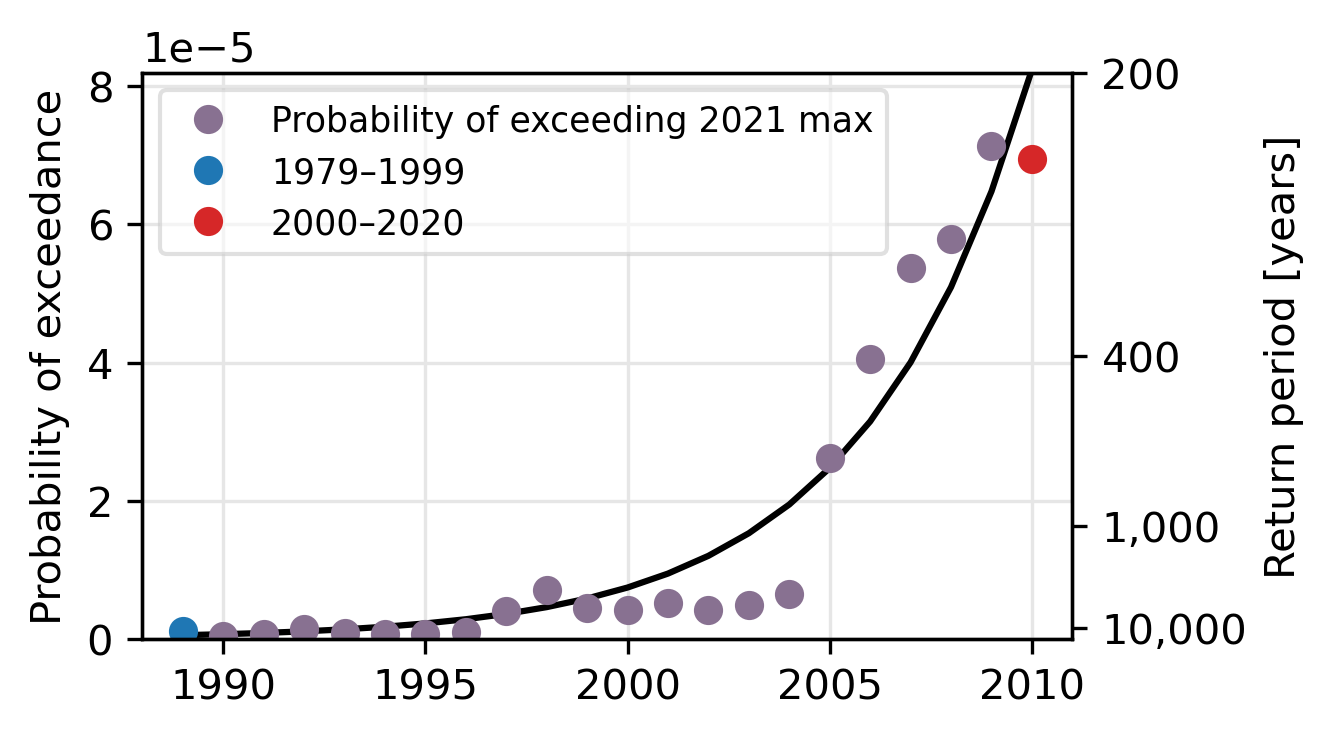

In [77]:
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=150)
ax2 = ax.twinx()

ax.plot(x + 1989, y1, color='0')

ax.plot(1990,sf80[p21],marker='o',ls='none',color='xkcd:greyish purple',label='Probability of exceeding 2021 max')
ax.plot(1989,sf79[p21],marker='o',ls='none',color='tab:blue',label='1979–1999')
ax.plot(1991,sf81[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(1992,sf82[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(1993,sf83[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(1994,sf84[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(1995,sf85[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(1996,sf86[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(1997,sf87[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(1998,sf88[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(1999,sf89[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2000,sf90[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2001,sf91[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2002,sf92[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2003,sf93[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2004,sf94[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2005,sf95[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2006,sf96[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2007,sf97[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2008,sf98[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2009,sf99[p21],marker='o',ls='none',color='xkcd:greyish purple')
ax.plot(2010,sf00[p21],marker='o',ls='none',color='tab:red',label='2000–2020')

ax.set_ylim(0,1/200/fac)

ax.set_ylabel('Probability of exceedance')
ax.set_xlim(1988,2011)
ax.grid(c='.9')
ax.legend(fontsize='small',framealpha=.6,loc='upper left').set_zorder(2)

ymin, ymax = ax.get_ylim()
ax2.set_ylim((ymin*fac),(ymax*fac))
ax2.set_ylabel('Return period [years]')
ax2.set_yticks((1/200,1/400,1/1000,1/10000))
ax2.set_yticklabels(('200','400','1,000','10,000'))


In [79]:
# detrend maxes

data = qq20.t2mland.groupby('time.year').max().sel(year=slice('1979','2020')) 
data79 = qq20.t2mland.groupby('time.year').max().sel(year=slice('1979','1999')) 
data00 = qq20.t2mland.groupby('time.year').max().sel(year=slice('2000','2020')) 
data21 = qq21.t2mland.groupby('time.year').max()

dataall = xr.concat([data,data21], dim='year')
slope,intc,_,_,_ = scipy.stats.linregress(data.year,data)
print(slope)
print(intc + slope * 1979)
hist_det = data - (data.year - data.year[0]) * slope
qq79_det = hist_det.sel(year=slice('1979','1999'))
qq81_det = hist_det.sel(year=slice('1981','2010'))
qq91_det = hist_det.sel(year=slice('1991','2020'))
qq00_det = hist_det.sel(year=slice('2000','2020'))
curr_det = xr.concat([hist_det, data21 - (data21.year - data.year[0]) * slope], dim='year')

dataallshift89 = curr_det + ((1989 - data.year[0]) * slope).values
dataallshift10 = curr_det + ((2010 - data.year[0]) * slope).values
dataallshift21 = curr_det + ((2021 - data.year[0]) * slope).values


0.04640717722204455
3.6719076571406504


In [81]:
p21 = np.argwhere(points>=data21.values)[0][0]


In [82]:
beg = data.year.min().values
print(beg)

fithist = gev.fit(hist_det)
print(fithist)
fit = gev.fit(curr_det)
print(fit)

pdfhist = gev.pdf(points, *fithist)
sfhist = gev.sf(points, *fithist)
pdf = gev.pdf(points, *fit)
sf = gev.sf(points, *fit)

sfhist_all = np.zeros((len(points),len(years)))
sf_all = np.zeros((len(points),len(years)))
for ii,yy in enumerate(years):
    sfhist_all[:,ii] = gev.sf(points, fithist[0], fithist[1] + (yy - beg) * slope, fithist[2])
    sf_all[:,ii] = gev.sf(points, fit[0], fit[1] + (yy - beg) * slope, fit[2])

sfhist79 = np.median(sfhist_all[:,1979-beg:1999-beg+1],1)
sfhist81 = np.median(sfhist_all[:,1981-beg:2010-beg+1],1)
sfhist91 = np.median(sfhist_all[:,1991-beg:2020-beg+1],1)
sfhist00 = np.median(sfhist_all[:,2000-beg:2020-beg+1],1)
sfhist21 = sfhist_all[:,2021-beg]
sfhist30 = sfhist_all[:,2030-beg]
sfhist40 = sfhist_all[:,2040-beg]
sfhist50 = sfhist_all[:,2050-beg]
sfhist60 = sfhist_all[:,2060-beg]
sfhist70 = sfhist_all[:,2070-beg]
sf8ist60 = sfhist_all[:,2080-beg]

sf79 = np.median(sf_all[:,1979-beg:1999-beg+1],1)
sf81 = np.median(sf_all[:,1981-beg:2010-beg+1],1)
sf91 = np.median(sf_all[:,1991-beg:2020-beg+1],1)
sf00 = np.median(sf_all[:,2000-beg:2020-beg+1],1)
sf21 = sf_all[:,2021-beg]
sf30 = sf_all[:,2030-beg]
sf40 = sf_all[:,2040-beg]
sf50 = sf_all[:,2050-beg]
sf60 = sf_all[:,2060-beg]
sf70 = sf_all[:,2070-beg]
sf80 = sf_all[:,2080-beg]


1979
(0.4241545536653552, 3.2878969598042875, 1.4277974933995192)
(0.1662850994425573, 3.1704598475933636, 1.4279248378257998)


In [15]:
### IGNORE ###

# Bootstraps for including-2021

# # Calculate bootstraps

# reps = 10000  # ~1.5 min per thousand

# n = len(curr_det.year)
# xb = np.random.choice(curr_det, (n, reps))

# sf_all_b = np.zeros((len(points),reps,len(curr_det.year)))
# for xx in range(reps):
#     fit_b = gev.fit(xb[:,xx])
#     for ii,yy in enumerate(curr_det.year):
#         sf_all_b[:,xx,ii] = gev.sf(points, fit_b[0], fit_b[1] + (yy - beg) * slope, fit_b[2])
#     if not xx % 100:
#         print(xx)

# xr.DataArray(data = sf_all_b, dims = ['points','reps','years'],coords = dict(points = ('points', points), reps = ('reps', np.arange(1,reps+1)), years = ('years', curr_det.year.values) ) ).to_netcdf('sf_all_b.nc')


# # Open from .nc

# sf_all_b = xr.open_dataarray('sf_all_b.nc')
# sf_all_5 = sf_all_b.quantile(.05,dim='reps')
# sf_all_95 = sf_all_b.quantile(.95,dim='reps')


In [16]:
### IGNORE ###

# Bootstraps for excluding-2021

# # Calculate bootstraps

# reps = 10000  # ~1.5 min per thousand

# n = len(hist_det.year)
# xb = np.random.choice(hist_det, (n, reps))

# sfhistall_b = np.zeros((len(points),reps,len(hist_det.year)))
# for xx in range(reps):
#     fit_b = gev.fit(xb[:,xx])
#     for ii,yy in enumerate(hist_det.year):
#         sfhistall_b[:,xx,ii] = gev.sf(points, fit_b[0], fit_b[1] + (yy - beg) * slope, fit_b[2])
#     if not xx % 100:
#         print(xx)

# xr.DataArray(data = sfhistall_b, dims = ['points','reps','years'],coords = dict(points = ('points', points), reps = ('reps', np.arange(1,reps+1)), years = ('years', hist_det.year.values) ) ).to_netcdf('sfhistall_b.nc')


# # Open from .nc

# sfhistall_b = xr.open_dataarray('sfhistall_b.nc')
# sfhistall_5 = sfhistall_b.quantile(.05,dim='reps')
# sfhistall_95 = sfhistall_b.quantile(.95,dim='reps')


In [19]:
# Open bootstrap percentiles

sf_all_5 = xr.open_dataarray('sf_all_5.nc').values
sf_all_95 = xr.open_dataarray('sf_all_95.nc').values
sfhistall_5 = xr.open_dataarray('sfhistall_5.nc').values
sfhistall_95 = xr.open_dataarray('sfhistall_95.nc').values


In [21]:
# Bootstrap intervals for historical periods

sf79_5 = np.median(sf_all_5[:,1979-beg:1999-beg+1],1)
sf81_5 = np.median(sf_all_5[:,1981-beg:2010-beg+1],1)
sf91_5 = np.median(sf_all_5[:,1991-beg:2020-beg+1],1)
sf00_5 = np.median(sf_all_5[:,2000-beg:2020-beg+1],1)
sf21_5 = sf_all_5[:,2021-beg]
sf79_95 = np.median(sf_all_95[:,1979-beg:1999-beg+1],1)
sf81_95 = np.median(sf_all_95[:,1981-beg:2010-beg+1],1)
sf91_95 = np.median(sf_all_95[:,1991-beg:2020-beg+1],1)
sf00_95 = np.median(sf_all_95[:,2000-beg:2020-beg+1],1)
sf21_95 = sf_all_95[:,2021-beg]


## _5d)_

Text(0, 0.5, 'Temperature [°C]')

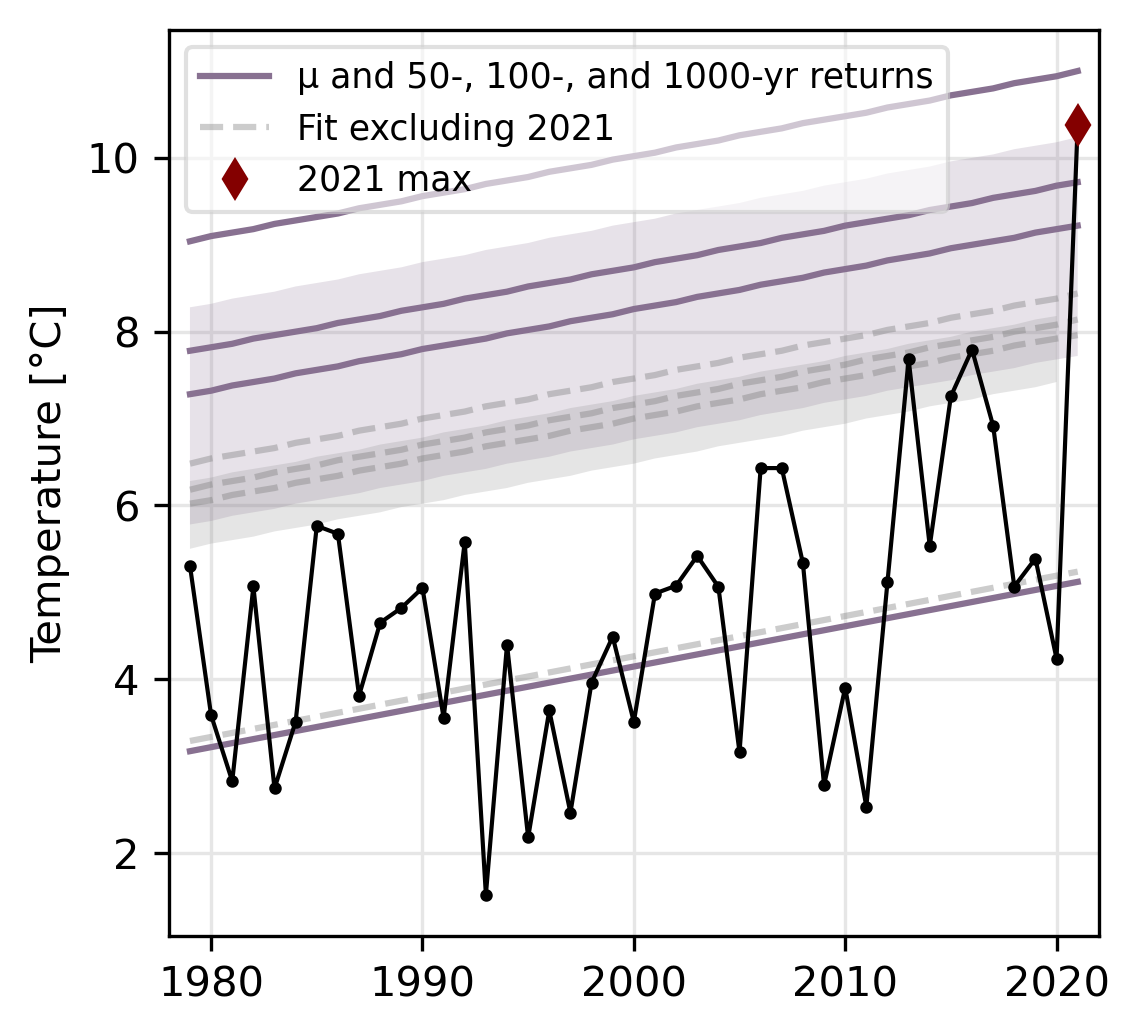

In [127]:
fig,ax = plt.subplots(1,1,dpi=150,figsize=(4,4))#2.75))
ax.grid(c='.9')

ax.plot(curr_det.year, fit[1] + (curr_det.year - beg) * slope, color='xkcd:greyish purple', label='μ and 50-, 100-, and 1000-yr returns')
ax.plot(curr_det.year, points[np.argmax((sf_all[:,:43]<1/50),axis=0)], color='xkcd:greyish purple')
ax.fill_between(curr_det.year, points[np.argmax((sf_all_5[:,:43]<1/50),axis=0)], points[np.argmax((sf_all_95[:,:43]<1/50),axis=0)], color='xkcd:greyish purple', edgecolor='none', alpha=.2, zorder=2)
ax.plot(curr_det.year, points[np.argmax((sf_all[:,:43]<1/100),axis=0)], color='xkcd:greyish purple')
ax.plot(curr_det.year, points[np.argmax((sf_all[:,:43]<1/1000),axis=0)], color='xkcd:greyish purple')

ax.plot(curr_det.year, fithist[1] + (curr_det.year - beg) * slope, color='.5', alpha=.4, ls='--', label='Fit excluding 2021')
ax.plot(curr_det.year, points[np.argmax((sfhist_all[:,:43]<1/50),axis=0)], color='.5', alpha=.4, ls='--')
ax.fill_between(hist_det.year, points[np.argmax((sfhistall_5[:,:43]<1/50),axis=0)], points[np.argmax((sfhistall_95[:,:43]<1/50),axis=0)], color='.5', edgecolor='none', alpha=.2, zorder=2)
ax.plot(curr_det.year, points[np.argmax((sfhist_all[:,:43]<1/100),axis=0)], color='.5', alpha=.4, ls='--')
ax.plot(curr_det.year, points[np.argmax((sfhist_all[:,:43]<1/1000),axis=0)], color='.5', alpha=.4, ls='--')

ax.plot(dataall.year, dataall, color='0', lw=1, marker='.', markersize=4)
ax.plot(data21.year, data21, marker='d', ls='none', color='xkcd:dark red', label='2021 max')

ax.legend(fontsize='small',loc='upper left',frameon=True,framealpha=.6)
ax.set_xlim(beg-1,2022)
ax.set_ylabel('Temperature anomaly [°C]')


## _5e)_

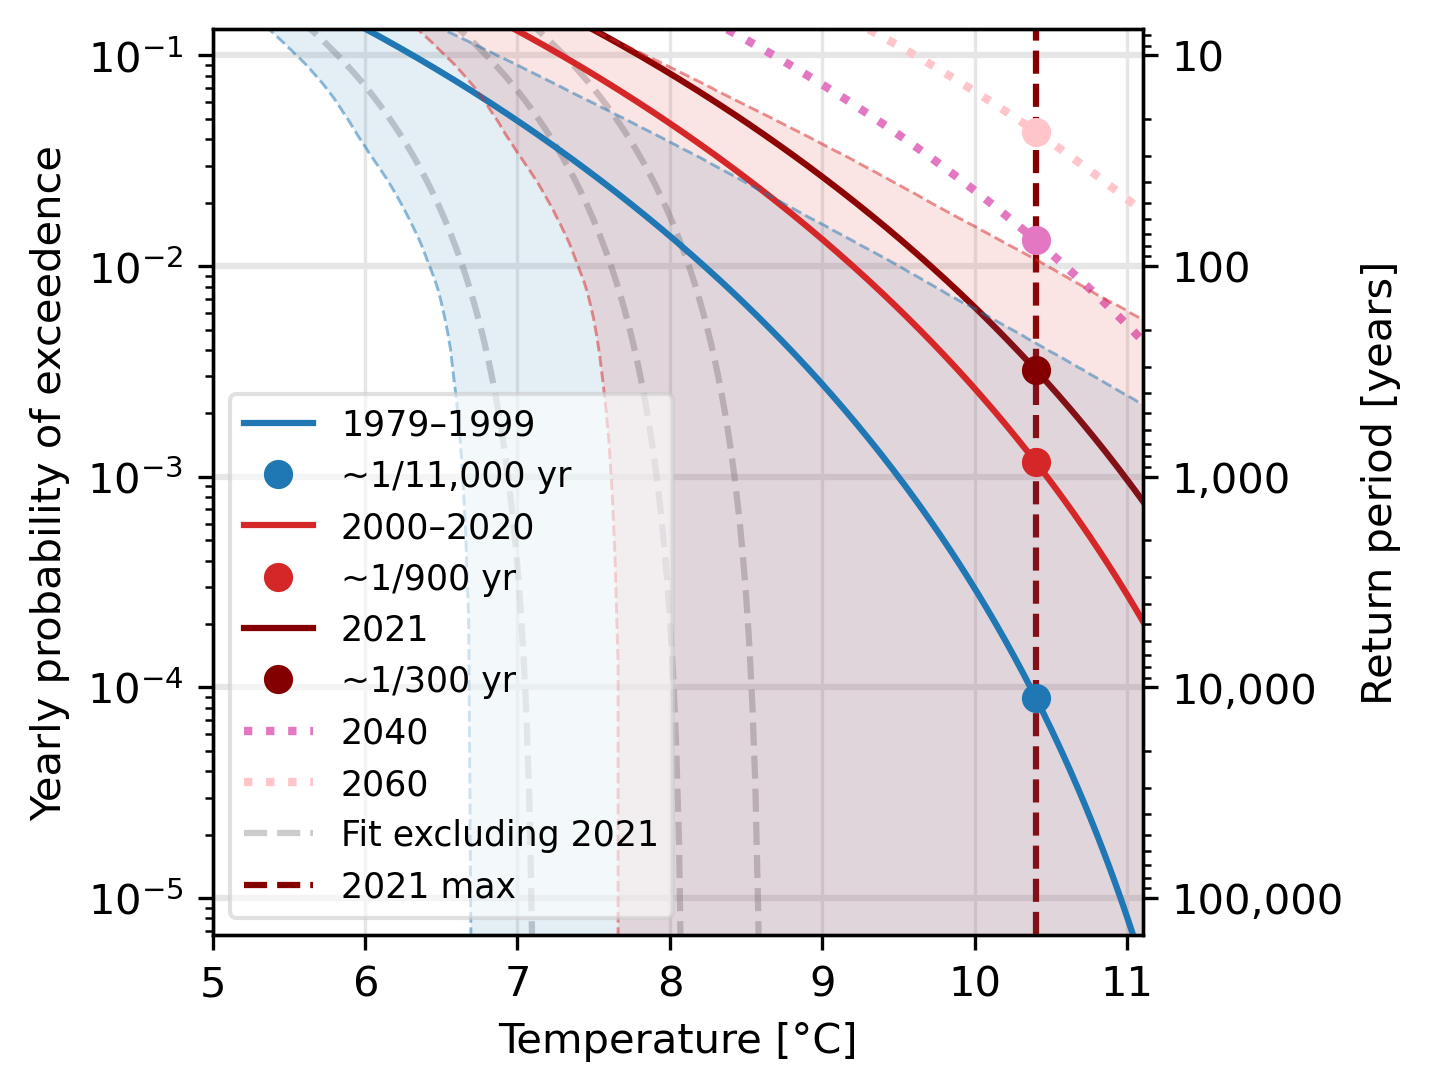

In [128]:
fig,ax = plt.subplots(1,1,dpi=150,figsize=(4,4))
ax2 = ax.twinx()

ax.grid(c='.9',zorder=1)

# curr:

ax.plot(points,sf79,color='tab:blue',lw=1.5,label='1979–1999',zorder=101)
ax.fill_between(points,sf79_5,sf79_95,color='tab:blue',edgecolor='none',alpha=.12,zorder=101)
ax.plot(points[p21],sf79[p21],color='tab:blue',ls='none',marker='o',label=f'~1/{int(round_to_n(1/sf79[p21],2)):,} yr',zorder=101)
ax.plot(points,sf00,color='tab:red',lw=1.5,label='2000–2020',zorder=101)
ax.fill_between(points,sf00_5,sf00_95,color='tab:red',edgecolor='none',alpha=.12,zorder=101)
ax.plot(points[p21],sf00[p21],color='tab:red',ls='none',marker='o',label=f'~1/{int(round_to_n(1/sf00[p21],1)):,} yr',zorder=101)
ax.plot(points,sf21,color='xkcd:dark red',lw=1.5,label='2021')
ax.plot(points[p21],sf21[p21],color='xkcd:dark red',ls='none',marker='o',label=f'~1/{int(round_to_n(1/sf21[p21],1)):,} yr',zorder=101)
ax.plot(points,sf40,color='tab:pink',lw=2,ls=':',label='2040')
ax.plot(points[p21],sf40[p21],color='tab:pink',ls='none',marker='o',zorder=101)
ax.plot(points,sf60,color='xkcd:light rose',lw=2,ls=':',label='2060')
ax.plot(points[p21],sf60[p21],color='xkcd:light rose',ls='none',marker='o',zorder=101)


# hist:

ax.plot(points,sfhist79,color='.5',lw=1.5,ls='--',alpha=.4,zorder=2)
ax.plot(points,sfhist00,color='.5',lw=1.5,ls='--',alpha=.4,zorder=2)
ax.plot(points,sfhist21,color='.5',lw=1.5,ls='--',alpha=.4,zorder=2)

ax.plot(points,sf79_5,color='tab:blue',ls='--',lw=.7,alpha=.5,zorder=500)
ax.plot(points,sf79_95,color='tab:blue',ls='--',lw=.7,alpha=.5,zorder=500)
ax.plot(points,sf00_5,color='tab:red',ls='--',lw=.7,alpha=.5,zorder=500)
ax.plot(points,sf00_95,color='tab:red',ls='--',lw=.7,alpha=.5,zorder=500)

ax.plot([],[],color='.5',lw=1.5,ls='--',alpha=.4,label='Fit excluding 2021')
ax.axvline(points[p21],c='xkcd:dark red',ls='--',label='2021 max',zorder=4)

ax.legend(fontsize='small',loc='lower left',framealpha=.6).set_zorder(501)
ax.set_xlim(5,11.1)
ax.set_ylim(1/(150000),1/(7.5))
ax.set_yscale('log')
ax.set_xlabel('Temperature anomaly [°C]')
ax.set_ylabel('Yearly probability of exceedence')

ax.axhline(1e-1,c='.9',zorder=1)
ax.axhline(1e-2,c='.9',zorder=1)
ax.axhline(1e-3,c='.9',zorder=1)
ax.axhline(1e-4,c='.9',zorder=1)
ax.axhline(1e-5,c='.9',zorder=1)

ymin, ymax = ax.get_ylim()
ax2.set_ylim((1/ymin),(1/ymax))
ax2.set_yscale('log')
ax2.plot([],[])
ax2.set_ylabel('Return period [years]')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:,.16g}'.format(y)))


## _5f)_

[Text(1, 0.125, '8'),
 Text(1, 0.1, '10'),
 Text(1, 0.05, '20'),
 Text(1, 0.01, '100'),
 Text(1, 0.001, '1,000')]

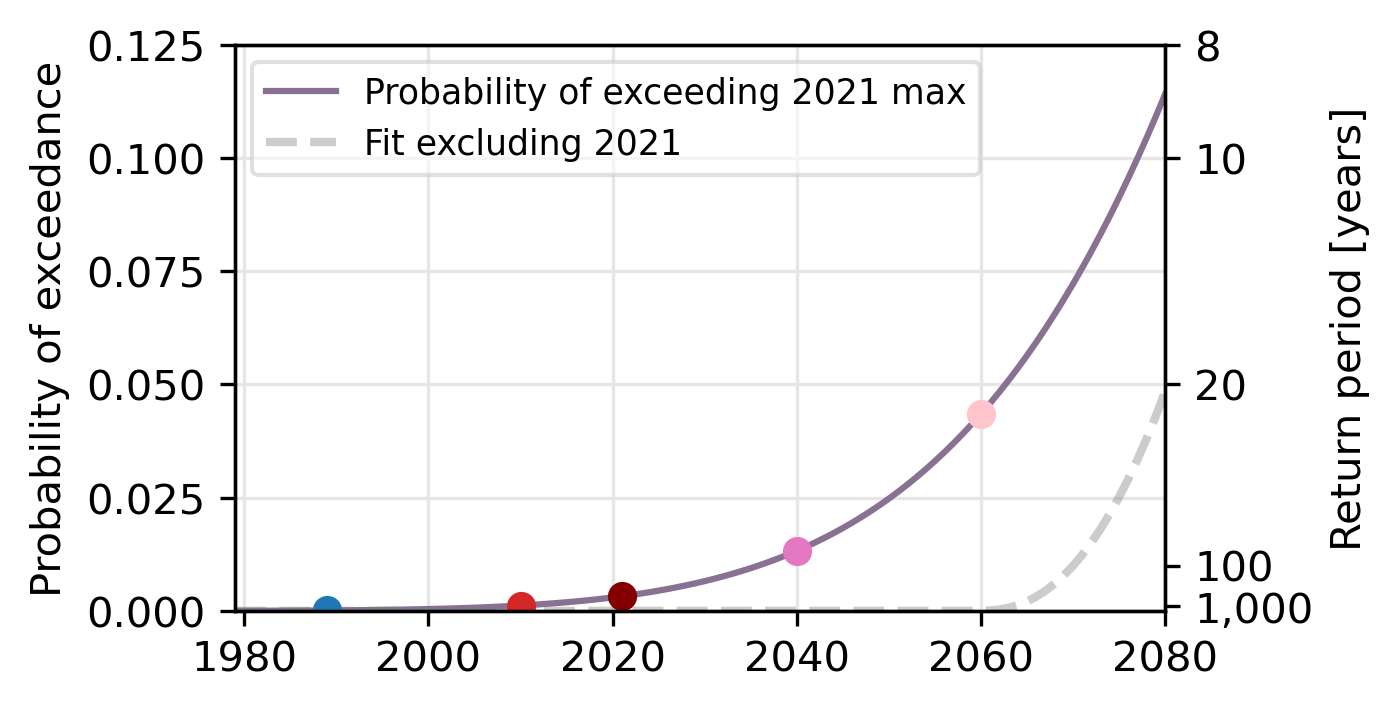

In [129]:
fig,ax = plt.subplots(1,1,figsize=(4,2.5),dpi=150)
ax2 = ax.twinx()
ax.plot(years, sf_all[p21,:],color='xkcd:greyish purple', label='Probability of exceeding 2021 max')
ax.plot(years, sfhist_all[p21,:],ls='--',lw=2,color='.5',alpha=.4, label='Fit excluding 2021')
ax.plot(1989,sf79[p21],marker='o',ls='none',color='tab:blue')
ax.plot(2010,sf00[p21],marker='o',ls='none',color='tab:red')
ax.plot(2021,sf21[p21],marker='o',ls='none',color='xkcd:dark red')
ax.plot(2040,sf40[p21],marker='o',ls='none',color='tab:pink')
ax.plot(2060,sf60[p21],marker='o',ls='none',color='xkcd:light rose')
ax.set_ylabel('Probability of exceedance')
ax.set_xlim(1979,2080)
ax.grid(c='.9')
ax.set_ylim(0,1/8)
ax.legend(fontsize='small',framealpha=.6)

ymin, ymax = ax.get_ylim()
ax2.set_ylim((ymin),(ymax))
ax2.set_ylabel('Return period [years]')
ax2.set_yticks((1/8,1/10,1/20,1/100,1/1000))
ax2.set_yticklabels(('8','10','20','100','1,000'))
